In [1]:
import pickle
from utils import *
import bert
lr_config = ModelArguments()
lr_config.num_labels = 2
lr_config.cache_size = 8
lr_config.cost = 1 #110M for bert-base
lr_model = pickle.load(open("models/lr_imdb_5000.pkl", "rb"))
lr_model.args = update_config(lr_model.args, lr_config)
lr_wrapper = ModelWrapper(lr_model, lr_model.args)
lr_wrapper.to('cuda')

bert_config = ModelArguments()
bert_config.num_labels = 2
bert_config.model = "./models/bert_imdb_5000"
bert_config.cache_size = 16
bert_config.cost = 63 #7B for llama2-7b
bert_model = bert.BertModel(bert_config)
bert_wrapper = ModelWrapper(bert_model, bert_model.args)
bert_wrapper.to('cuda')

BERT Model loaded


ModelWrapper(
  (linear): Linear(in_features=2, out_features=3, bias=True)
  (activation): Sigmoid()
)

In [2]:
import datasets
import torch
import tqdm
set_seed(42)
data = datasets.load_from_disk("data/5000_sampled_imdb_test")
data = data.shuffle()
lr_collection = []
bert_collection = []
bar = tqdm.tqdm(range(len(data)))
for i, item in enumerate(data):
    text = item['text']
    lr_decision, lr_prob = lr_wrapper(text)
    lr_pred = torch.argmax(lr_prob, dim=-1).item()
    
    bert_decision, bert_prob = bert_wrapper(text)
    bert_pred = torch.argmax(bert_prob, dim=-1).item()

    lr_correctness = (lr_pred == item['label'])
    bert_correctness = (bert_pred == item['label'])

    # compute normalized entropy
    lr_entropy = normalized_entropy(lr_prob, gamma=1)
    bert_entropy = normalized_entropy(bert_prob, gamma=1)

    lr_collection.append((torch.max(lr_prob).item(), lr_entropy.item(), lr_correctness, lr_prob.tolist()))
    bert_collection.append((torch.max(bert_prob).item(), bert_entropy.item(), bert_correctness, bert_prob.tolist()))
    bar.update(1)

100%|█████████▉| 4999/5000 [01:08<00:00, 74.72it/s]

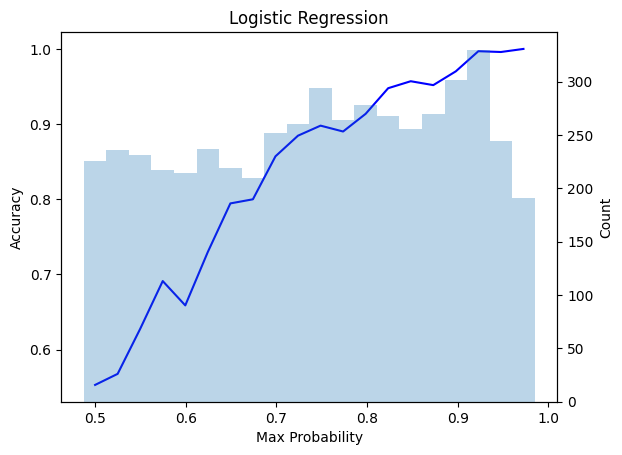

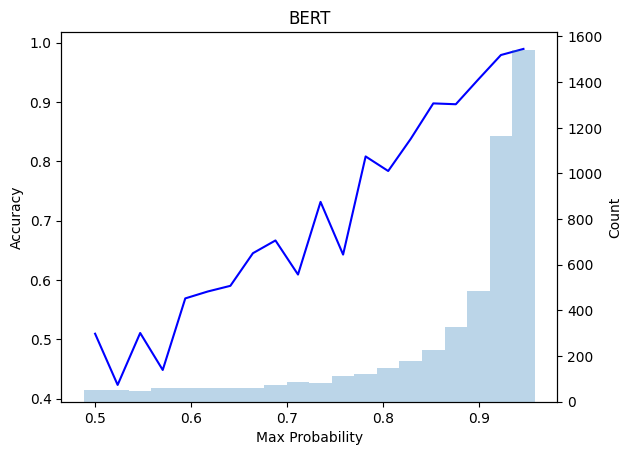

In [3]:
import matplotlib.pyplot as plt

def plot_prob_accuracy(collection, title):
    bin_num = 20
    collection.sort(key=lambda x: x[0])
    # divide the bins based on max prob
    prob_diff = max([x[0] for x in collection]) - min([x[0] for x in collection])
    bin_size = prob_diff / bin_num
    bins = [min([x[0] for x in collection]) + bin_size * i for i in range(bin_num+1)]
    bin_correctness = [[] for i in range(bin_num)]
    for item in collection:
        for i in range(bin_num):
            if item[0] >= bins[i] and item[0] < bins[i+1]:
                bin_correctness[i].append(item[2])
                break
    # calculate accuracy
    bin_accuracy = [sum(x)/len(x) for x in bin_correctness]

    bin_count = [0 for i in range(bin_num)]
    for item in collection:
        for i in range(bin_num):
            if item[0] >= bins[i] and item[0] < bins[i+1]:
                bin_count[i] += 1
                break
    # plot the plot and bar chart together
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(bins[:-1], bin_accuracy, 'b-')
    ax2.bar(bins[:-1], bin_count, alpha=0.3, width=bin_size)
    ax1.set_xlabel("Max Probability")
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Count")
    ax1.set_title(title)
    plt.show()


plot_prob_accuracy(lr_collection, "Logistic Regression")
plot_prob_accuracy(bert_collection, "BERT")

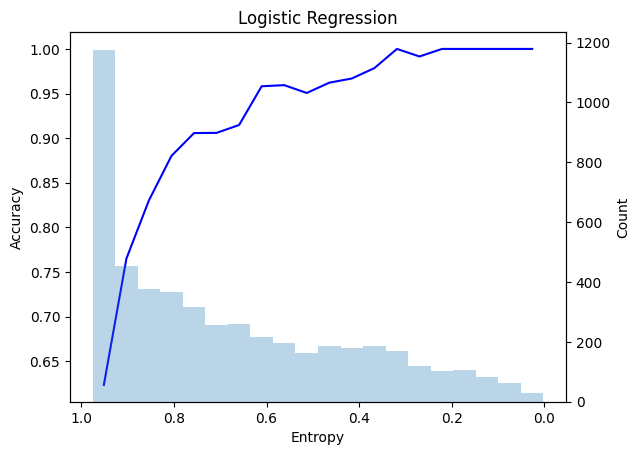

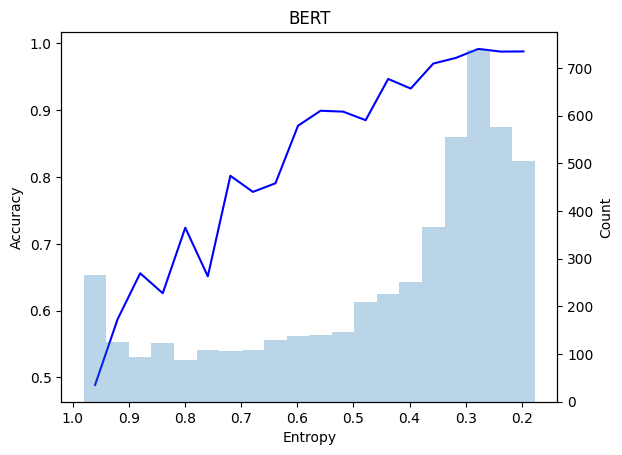

In [37]:
def plot_entropy_accuracy(collection, title):
    bin_num = 20
    collection.sort(key=lambda x: x[1])
    # divide the bins based on max prob
    prob_diff = max([x[1] for x in collection]) - min([x[1] for x in collection])
    bin_size = prob_diff / bin_num
    bins = [min([x[1] for x in collection]) + bin_size * i for i in range(bin_num+1)]
    bin_correctness = [[] for i in range(bin_num)]
    for item in collection:
        for i in range(bin_num):
            if item[1] >= bins[i] and item[1] < bins[i+1]:
                bin_correctness[i].append(item[2])
                break
    # calculate accuracy
    bin_accuracy = [sum(x)/len(x) for x in bin_correctness]

    bin_count = [0 for i in range(bin_num)]
    for item in collection:
        for i in range(bin_num):
            if item[1] >= bins[i] and item[1] < bins[i+1]:
                bin_count[i] += 1
                break
    # plot the plot and bar chart together
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(bins[:-1], bin_accuracy, 'b-')
    ax2.bar(bins[:-1], bin_count, alpha=0.3, width=bin_size)
    # reverse the x axis
    ax1.set_xlim(ax1.get_xlim()[::-1])
    ax1.set_xlabel("Entropy")
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Count")
    ax1.set_title(title)
    plt.show()

plot_entropy_accuracy(lr_collection, "Logistic Regression")
plot_entropy_accuracy(bert_collection, "BERT")

In [20]:
import sklearn

meta_classifier = sklearn.svm.SVC()
meta_classifier.fit([x[-1][-1]+[x[0],x[1]] for x in bert_collection[:2500]], [int(x[2]) for x in bert_collection[:2500]])
print(meta_classifier.score([x[-1][-1]+[x[0],x[1]] for x in bert_collection[2500:]], [int(x[2]) for x in bert_collection[2500:]]))
print(meta_classifier.predict([x[-1][-1]+[x[0],x[1]] for x in bert_collection[2500:]]).tolist().count(1)/len(bert_collection[2500:]))


0.9052
0.9216


In [16]:
meta_classifier = sklearn.svm.SVC()
meta_classifier.fit([x[-1][-1]+[x[0],x[1]] for x in lr_collection[:2500]], [int(x[2]) for x in lr_collection[:2500]])
print(meta_classifier.score([x[-1][-1]+[x[0],x[1]] for x in lr_collection[2500:]], [int(x[2]) for x in lr_collection[2500:]]))
print(meta_classifier.predict([x[-1][-1]+[x[0],x[1]] for x in lr_collection[2500:]]).tolist().count(1)/len(lr_collection[2500:]))

0.8404
1.0


imdb_post_1_0.0040_offline.log
imdb_post_1_0.0060_offline.log
imdb_post_1_0.0080_offline.log
imdb_post_1_0.0100_offline.log
imdb_post_1_0.0120_offline.log
imdb_post_1_0.0140_offline.log
imdb_post_1_0.0150_offline.log
imdb_post_1_0.0160_offline.log
imdb_post_1_0.0180_offline.log
imdb_post_1_0.0200_offline.log
imdb_post_1_0.0220_offline.log
imdb_post_1_0.0240_offline.log
imdb_post_1_0.0250_offline.log
imdb_post_1_0.0260_offline.log
imdb_post_1_0.0280_offline.log
imdb_post_1_0.0300_offline.log
imdb_post_1_0.0320_offline.log
imdb_post_1_0.0340_offline.log
imdb_post_1_0.0360_offline.log
imdb_post_1_0.0380_offline.log
imdb_post_1_0.0400_offline.log
imdb_post_1_0.0420_offline.log
imdb_post_1_0.0440_offline.log
imdb_post_1_0.0460_offline.log


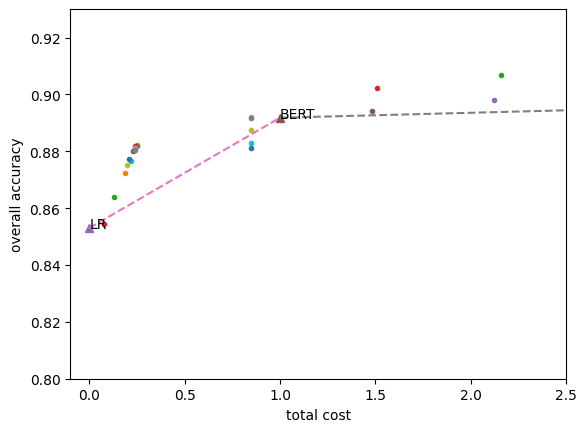

In [21]:
# open all .log files in the current directory and plot the data
import matplotlib.pyplot as plt
import numpy as np
import os
import re
# %matplotlib widget

# get all .log files in the ./logs/ directory
files = [f for f in os.listdir('./logs/') if f.endswith('.log') and 'post_1' in f]
files.sort()
costs = []
accus = []
# plot the data
for f in files:
    print(f)
    # read last line of the file
    with open('./logs/' + f, 'r') as file:
        last_line = file.readlines()[-2]
    # data format: '''lr_prediction, bert_prediction, ground_truth, lr_proportion, bert_proportion, lr_defer_prob, bert_defer_prob, lr_cost, bert_cost, cost, lr_accuracy, bert_accuracy, overall_accuracy'''
    data = re.split(',', last_line.strip())
    lr_proportion = float(data[3])
    bert_proportion = float(data[4])
    # total_cost = lr_proportion * 1 + bert_proportion * 17 + (1 - lr_proportion - bert_proportion) * 2553
    total_cost = bert_proportion + (1 - lr_proportion - bert_proportion) * 63
    overall_accuracy = float(data[-1])
    # plot a line
    plt.plot(total_cost, overall_accuracy, '.')
    costs.append(total_cost)
    accus.append(overall_accuracy)
    # plt.annotate(f.split('_')[3], (total_cost, overall_accuracy))

# sort the data then plot
costs = np.array(costs)
accus = np.array(accus)
idx = np.argsort(costs)
costs = costs[idx]
accus = accus[idx]
# plt.plot(costs, accus)

# plot the baseline point
plt.plot(0, 0.853, '^')
plt.annotate('LR', (0, 0.853))
plt.plot(1, 0.8918, '^')
plt.annotate('BERT', (1, 0.8918))
# draw a line between the two points
plt.plot([0, 1], [0.853, 0.8918], '--')
# draw a line between (1, 0.8918) and (63, 1)
plt.plot([1, 63], [0.8918, 1], '--')



plt.xlabel('total cost')
plt.ylabel('overall accuracy')
# set y axis range
plt.ylim(0.8, 0.93)
plt.xlim(-0.1, 2.5)
plt.show()


imdb_online_0_0.0010.log
imdb_online_0_0.0020.log
imdb_online_0_0.0030.log
imdb_online_0_0.0040.log
imdb_online_0_0.0050.log
imdb_online_0_0.0060.log
imdb_online_0_0.0070.log
imdb_online_0_0.0080.log
imdb_online_0_0.0090.log
imdb_online_0_0.0100.log
imdb_online_0_0.0110.log
imdb_online_0_0.0120.log
imdb_online_0_0.0130.log
imdb_online_0_0.0140.log
imdb_online_0_0.0150.log
imdb_online_0_0.0160.log
imdb_online_0_0.0170.log
imdb_online_0_0.0180.log
imdb_online_0_0.0190.log
imdb_online_0_0.0200.log
imdb_online_0_0.0210.log
imdb_online_0_0.0220.log
imdb_online_0_0.0230.log
imdb_online_0_0.0240.log
imdb_online_0_0.0250.log
imdb_online_0_0.0260.log
imdb_online_0_0.0270.log
imdb_online_0_0.0280.log
imdb_online_0_0.0290.log
imdb_online_0_0.0300.log
imdb_online_0_0.0320.log
imdb_online_0_0.0340.log
imdb_online_0_0.0350.log
imdb_online_0_0.0360.log
imdb_online_0_0.0380.log
imdb_online_0_0.0400.log
imdb_online_0_0.0450.log


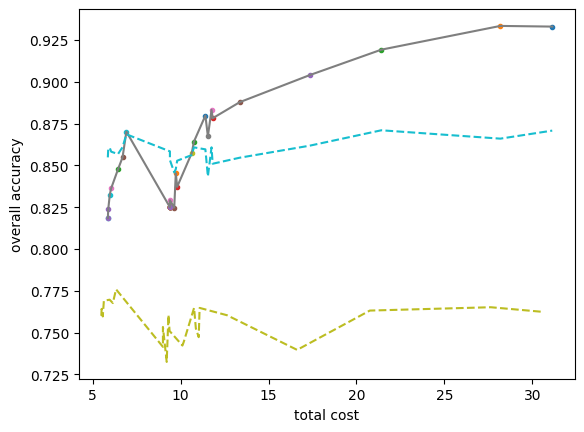

In [2]:
# open all .log files in the current directory and plot the data
import matplotlib.pyplot as plt
import numpy as np
import os
import re
# %matplotlib widget

# get all .log files in the ./logs/ directory
files = [f for f in os.listdir('./logs/') if f.endswith('.log') and 'imdb' in f and 'online_0' in f]
files.sort()
costs = []
accus = []
lr_acc, bert_acc = [], []
# plot the data
for f in files:
    print(f)
    # read last line of the file
    with open('./logs/' + f, 'r') as file:
        last_line = file.readlines()[-2]
    # data format: '''lr_prediction, bert_prediction, ground_truth, lr_proportion, bert_proportion, lr_defer_prob, bert_defer_prob, lr_cost, bert_cost, cost, lr_accuracy, bert_accuracy, overall_accuracy'''
    data = re.split(',', last_line.strip())
    lr_proportion = float(data[4])
    bert_proportion = float(data[5])
    llm_proportion = 1-lr_proportion-bert_proportion
    total_cost = bert_proportion + llm_proportion * 63
    overall_accuracy = float(data[-1])
    lr_acc.append((llm_proportion*63, float(data[-4])))
    bert_acc.append((bert_proportion*1 + llm_proportion*63, float(data[-3])))
    plt.plot(total_cost, overall_accuracy, '.')
    # plot as a line
    costs.append(total_cost)
    accus.append(overall_accuracy)

# sort the data then plot
costs = np.array(costs)
accus = np.array(accus)
idx = np.argsort(costs)
costs = costs[idx]
accus = accus[idx]
plt.plot(costs, accus)

# plot the lr baseline point as line
lr_acc.sort(key=lambda x: x[0])
lr_acc = np.array(lr_acc)
plt.plot(lr_acc[:, 0], lr_acc[:, 1], '--')
# plot the bert baseline point as line
bert_acc.sort(key=lambda x: x[0])
bert_acc = np.array(bert_acc)
plt.plot(bert_acc[:, 0], bert_acc[:, 1], '--')


plt.xlabel('total cost')
plt.ylabel('overall accuracy')
# set y axis range
# plt.ylim(0.8, 0.93)
# plt.xlim(-0.1, 2.5)
plt.show()


In [50]:
sns.color_palette('muted')

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

/tmp/ipykernel_32604/3878875373.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])


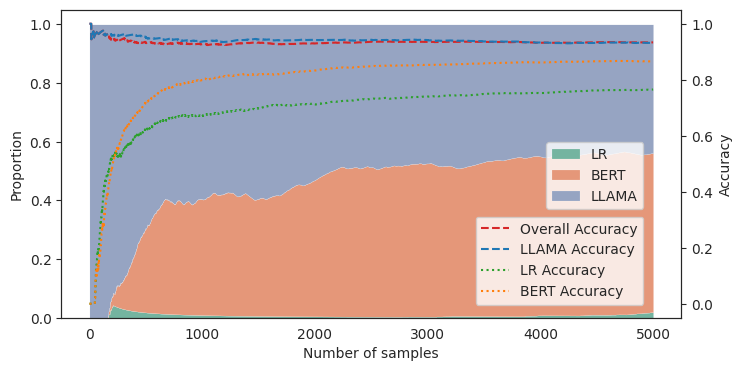

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import seaborn
# set seaborn style as whitegrid
seaborn.set_style("white")
colors = sns.color_palette("Set2", desat=.7)
colors2 = sns.color_palette()

lr_proportion, bert_proportion, llm_proportion = [], [], []
lr_acc, bert_acc, llama_acc, overall_acc = [], [], [], []
lr_real_acc, bert_real_acc = [], []
with open('./logs/imdb_online_0_0.0020.log') as file:
    for line in file.readlines():
        line = line.replace('na', '0')
        data = line.strip().split(',')
        lr_proportion.append(float(data[4]))
        bert_proportion.append(float(data[5]))
        llm_proportion.append(1-float(data[4])-float(data[5]))
        lr_acc.append(float(data[-6]))
        bert_acc.append(float(data[-5]))
        lr_real_acc.append(float(data[-4]))
        bert_real_acc.append(float(data[-3]))
        llama_acc.append(float(data[-2]))
        overall_accuracy = float(data[-1])
        overall_acc.append(overall_accuracy)
    


# plot the proportion on a stacked plot

fig, ax1 = plt.subplots()
ax1.stackplot(range(5000), lr_proportion, bert_proportion, llm_proportion, labels=['LR', 'BERT', 'LLAMA'], colors=colors, edgecolor='white', linewidth=0.1)
# set a color less transparent
ax1.set_xlabel('Number of samples')
ax1.set_ylabel('Proportion')
ax1.legend(loc='lower right', framealpha=.8,  bbox_to_anchor=(0.95, 0.33))

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')

ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])

ax2.plot(llama_acc, '--', label='LLAMA Accuracy', color=colors2[0])


# ax2.plot(lr_acc, '--', label='LR Accuracy', color=colors2[2])
ax2.plot(lr_real_acc, ':', label='LR Accuracy', color=colors2[2])

# ax2.plot(bert_acc, '--', label='BERT Accuracy', color=colors2[1])
ax2.plot(bert_real_acc, ':', label='BERT Accuracy', color=colors2[1])


ax2.legend(loc='lower right', framealpha=.8, bbox_to_anchor=(0.95, 0.02))

fig.set_size_inches(8, 4)
plt.show()
# save as pdf
fig.savefig('imdb_0.002.pdf', dpi=300, bbox_inches='tight')

In [10]:
lr_proportion

[0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0

agnews

In [114]:
lr_fine_tuned = [(0.1, 0.6252),
 (0.15000000000000002, 0.626),
 (0.25000000000000006, 0.6366),
 (0.40000000000000013, 0.6512),
 (0.45000000000000007, 0.6622),
 (0.5000000000000001, 0.6678),
 (0.5500000000000002, 0.6536),
 (0.6000000000000002, 0.674),
 (0.6500000000000001, 0.675),
 (0.8000000000000002, 0.6758),
 (0.8500000000000002, 0.6754),
 (0.9000000000000002, 0.6596),
 (0.9500000000000003, 0.6512)]

for idx, i in enumerate(lr_fine_tuned):
    lr_fine_tuned[idx] = (i[0]*63, i[1])

bert_fine_tuned = [(0.1, 0.7508),
 (0.15000000000000002, 0.7272),
 (0.20000000000000004, 0.6932),
 (0.25000000000000006, 0.6992),
 (0.30000000000000004, 0.6906),
 (0.5500000000000002, 0.6826),
 (0.6000000000000002, 0.7062),
 (0.6500000000000001, 0.6928),
 (0.700000000000007, 0.70),
 (0.8000000000000001, 0.71),
 (0.900000000000002, 0.722),
 (0.95000000000000002, 0.7242)]
for idx, i in enumerate(bert_fine_tuned):
    bert_fine_tuned[idx] = (i[0]*63, i[1]-0.02)

0.0001.log
0.0002.log
0.0003.log
0.0004.log
0.0005.log
0.0006.log
0.0007.log
0.0008.log
0.0009.log
0.0015.log
0.0025.log
0.0035.log
0.0045.log
0.0055.log
0.0060.log
0.0065.log
0.0070.log
0.0075.log
0.0080.log
0.0085.log
0.0090.log
0.0095.log
0.0105.log
0.0115.log
0.0125.log
0.0145.log
0.0155.log
0.0165.log
0.0175.log
0.0185.log
0.0195.log


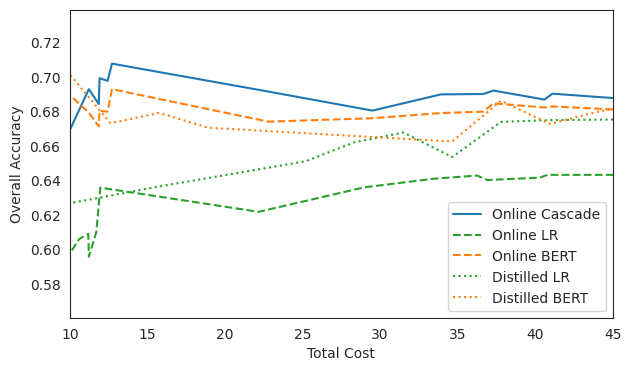

In [115]:
# open all .log files in the current directory and plot the data
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import seaborn as sns
colors = sns.color_palette()
sns.set_style("white")

# get all .log files in the ./logs/ directory
files = [f for f in os.listdir('./logs/online_cascade/agnews/') if f.endswith('.log') and '0.013' not in f]
files.sort()
costs = []
accus = []
lr_acc, bert_acc = [], []
# plot the data
for f in files:
    print(f)
    # read last line of the file
    try:
        with open('./logs/online_cascade/agnews/' + f, 'r') as file:
            lines = file.readlines()
            line_num = len(lines)
            if line_num < 4000:
                continue
            
            last_line = lines[-2]
        # data format: '''lr_prediction, bert_prediction, ground_truth, lr_proportion, bert_proportion, lr_defer_prob, bert_defer_prob, lr_cost, bert_cost, cost, lr_accuracy, bert_accuracy, overall_accuracy'''
        data = re.split(',', last_line.strip())
        lr_proportion = float(data[4])
        bert_proportion = float(data[5])
        llm_proportion = 1-lr_proportion-bert_proportion
        total_cost = bert_proportion + llm_proportion * 63
        overall_accuracy = float(data[-1])
        lr_acc.append((llm_proportion*63, float(data[-4])))
        bert_acc.append((bert_proportion*1 + llm_proportion*63, float(data[-3])))
        # plot a line
        # plt.plot(total_cost, overall_accuracy, '.')
        costs.append(total_cost)
        accus.append(overall_accuracy)
    except:
        print(f)

# sort the data then plot
costs = np.array(costs)
accus = np.array(accus)
idx = np.argsort(costs)
costs = costs[idx]
accus = accus[idx]
plt.plot(costs, accus, label='Online Cascade', color=colors[0])

# plot the lr baseline point as line
lr_acc.sort(key=lambda x: x[0])
lr_acc = np.array(lr_acc)
plt.plot(lr_acc[:, 0], lr_acc[:, 1], '--', label='Online LR', color=colors[2])
# plot the bert baseline point as line
bert_acc.sort(key=lambda x: x[0])
bert_acc = np.array(bert_acc)
for idx, i in enumerate(bert_acc):
    bert_acc[idx] = (i[0], i[1]-0.01)
plt.plot(bert_acc[:, 0], bert_acc[:, 1], '--', label='Online BERT', color=colors[1])

# plot the lr fine-tuned point as line
lr_fine_tuned.sort(key=lambda x: x[0])
lr_fine_tuned = np.array(lr_fine_tuned)
plt.plot(lr_fine_tuned[:, 0], lr_fine_tuned[:, 1], ':', label='Distilled LR', color=colors[2])

# plot the bert fine-tuned point as line
bert_fine_tuned.sort(key=lambda x: x[0])
bert_fine_tuned = np.array(bert_fine_tuned)
plt.plot(bert_fine_tuned[:, 0], bert_fine_tuned[:, 1], ':', label='Distilled BERT', color=colors[1])
# set name
plt.legend(loc='lower right')
plt.xlabel('Total Cost')
plt.ylabel('Overall Accuracy')
# set y axis range
# plt.ylim()
plt.xlim(10, 45)
# set figure size
plt.gcf().set_size_inches(7, 4)
plt.savefig('agnews_online.pdf', dpi=300, bbox_inches='tight')

plt.show()
# save as pdf


/tmp/ipykernel_32604/1315350726.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])


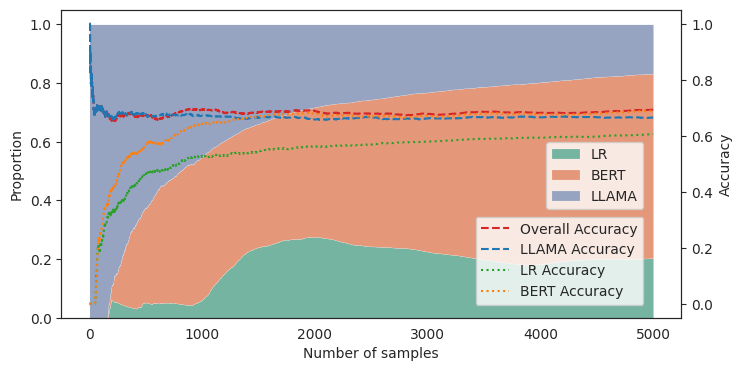

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import seaborn
# set seaborn style as whitegrid
seaborn.set_style("white")
colors = sns.color_palette("Set2", desat=.7)
colors2 = sns.color_palette()

lr_proportion, bert_proportion, llm_proportion = [], [], []
lr_acc, bert_acc, llama_acc, overall_acc = [], [], [], []
lr_real_acc, bert_real_acc = [], []
with open('./logs/online_cascade/agnews/0.0115.log') as file:
    for line in file.readlines():
        line = line.replace('na', '0')
        data = line.strip().split(',')
        lr_proportion.append(float(data[4]))
        bert_proportion.append(float(data[5]))
        llm_proportion.append(1-float(data[4])-float(data[5]))
        lr_acc.append(float(data[-6]))
        bert_acc.append(float(data[-5]))
        lr_real_acc.append(float(data[-4]))
        bert_real_acc.append(float(data[-3]))
        llama_acc.append(float(data[-2]))
        overall_accuracy = float(data[-1])
        overall_acc.append(overall_accuracy)
    


# plot the proportion on a stacked plot

fig, ax1 = plt.subplots()
ax1.stackplot(range(5000), lr_proportion, bert_proportion, llm_proportion, labels=['LR', 'BERT', 'LLAMA'], colors=colors, edgecolor='white', linewidth=0.1)
# set a color less transparent
ax1.set_xlabel('Number of samples')
ax1.set_ylabel('Proportion')
ax1.legend(loc='lower right', framealpha=.8,  bbox_to_anchor=(0.95, 0.33))

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')

ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])

ax2.plot(llama_acc, '--', label='LLAMA Accuracy', color=colors2[0])


# ax2.plot(lr_acc, '--', label='LR Accuracy', color=colors2[2])
ax2.plot(lr_real_acc, ':', label='LR Accuracy', color=colors2[2])

# ax2.plot(bert_acc, '--', label='BERT Accuracy', color=colors2[1])
ax2.plot(bert_real_acc, ':', label='BERT Accuracy', color=colors2[1])


ax2.legend(loc='lower right', framealpha=.8, bbox_to_anchor=(0.95, 0.02))

fig.set_size_inches(8, 4)
plt.show()
# save as pdf
fig.savefig('agnews_0.0115.pdf', dpi=300, bbox_inches='tight')

hatespeech

In [142]:
lr_pos_total, bert_pos_total, llm_pos_total, overall_pos_total

(592, 592, 103, 601)

In [146]:
lr_fine_tuned = [(0.1, 0.8292227204783259),
 (0.15000000000000002, 0.8110986547085202),
 (0.20000000000000004, 0.804932735426009),
 (0.25000000000000006, 0.8178251121076233),
 (0.30000000000000004, 0.8460388639760837),
 (0.3500000000000001, 0.8185724962630793),
 (0.40000000000000013, 0.8361360239162929),
 (0.45000000000000007, 0.8103512705530643),
 (0.5000000000000001, 0.8385650224215246),
 (0.5500000000000002, 0.84398355754858),
 (0.6000000000000002, 0.8497757847533632),
 (0.6500000000000001, 0.8579970104633782),
 (0.7000000000000002, 0.8542600896860987),
 (0.7500000000000002, 0.8557548579970105),
 (0.8000000000000002, 0.8710762331838565),
 (0.8500000000000002, 0.8550074738415545),
 (0.9000000000000002, 0.874626307922272),
 (0.9500000000000003, 0.8613602391629297)]

for idx, i in enumerate(lr_fine_tuned):
    lr_fine_tuned[idx] = (i[0]*63, i[1])

bert_fine_tuned = [(0.1, 0.7508),
 (0.15000000000000002, 0.7272),
 (0.20000000000000004, 0.6932),
 (0.25000000000000006, 0.6992),
 (0.30000000000000004, 0.6906),
 (0.5500000000000002, 0.6826),
 (0.6000000000000002, 0.7062),
 (0.6500000000000001, 0.6928),
 (0.700000000000007, 0.70),
 (0.8000000000000001, 0.71),
 (0.900000000000002, 0.722),
 (0.95000000000000002, 0.7242)]
for idx, i in enumerate(bert_fine_tuned):
    bert_fine_tuned[idx] = (i[0]*63, i[1]-0.02)

0.0010.log
0.0020.log
0.0030.log
0.0040.log
0.0050.log
0.0060.log
0.0070.log
0.0080.log
0.0090.log
0.0100.log
0.0110.log
0.0120.log
0.0130.log
0.0140.log
0.0150.log
0.0160.log
0.0170.log
0.0180.log


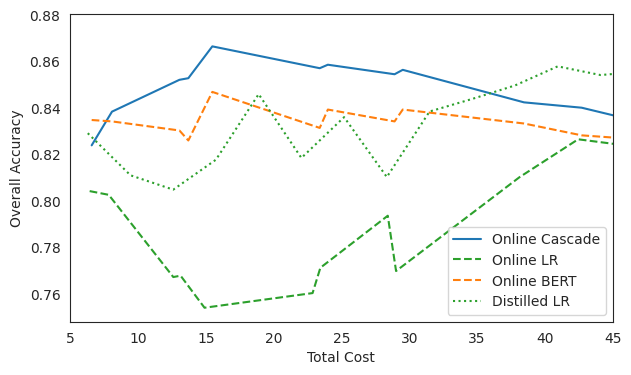

In [147]:
# open all .log files in the current directory and plot the data
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import seaborn as sns
colors = sns.color_palette()
sns.set_style("white")

# get all .log files in the ./logs/ directory
files = [f for f in os.listdir('./logs/online_cascade/hatespeech/') if f.endswith('.log') and '190' not in f ]
files.sort()
costs = []
accus = []
lr_acc, bert_acc = [], []
lr_pos_acc, bert_pos_acc, llm_pos_acc, overall_pos_acc = [], [], [], []
# plot the data
for f in files:
    print(f)
    # read last line of the file
    
    with open('./logs/online_cascade/hatespeech/' + f, 'r') as file:
        lines = file.readlines()
        line_num = len(lines)
        if line_num < 4999:
            continue
        lr_pos_correct, bert_pos_correct, llm_pos_correct, overall_pos_correct = 0,0,0,0
        lr_pos_total, bert_pos_total, llm_pos_total, overall_pos_total = 0,0,0,0
        for l in lines:
            info = l.split(',')
            lr_pred, bert_pred, llm_pred, gt = info[0], info[1], info[2], info[3]
            if gt == '1':
                if lr_pred == gt:
                    lr_pos_correct += 1
                if bert_pred == gt:
                    bert_pos_correct += 1
                if llm_pred == gt:
                    llm_pos_correct += 1
                if lr_pred != '-1':
                    lr_pos_total += 1
                if bert_pred != '-1':
                    bert_pos_total += 1
                if llm_pred != '-1':
                    llm_pos_total += 1
                try:
                    if float(info[4]) < 0.5:
                        if lr_pred == gt:
                            overall_pos_correct += 1
                    elif float(info[4]) > 0.5 and float(info[5]) < 0.5:
                        if bert_pred == gt:
                            overall_pos_correct += 1
                    else:
                        if llm_pred == gt:
                            overall_pos_correct += 1
                except:
                    if llm_pred == gt:
                        overall_pos_correct += 1
                overall_pos_total += 1

        lr_pos_acc.append(lr_pos_correct/lr_pos_total)
        bert_pos_acc.append(bert_pos_correct/bert_pos_total)
        llm_pos_acc.append(llm_pos_correct/llm_pos_total)
        overall_pos_acc.append(overall_pos_correct/overall_pos_total)
        last_line = lines[-2]
    # data format: '''lr_prediction, bert_prediction, ground_truth, lr_proportion, bert_proportion, lr_defer_prob, bert_defer_prob, lr_cost, bert_cost, cost, lr_accuracy, bert_accuracy, overall_accuracy'''
    data = re.split(',', last_line.strip())
    lr_proportion = float(data[4])
    bert_proportion = float(data[5])
    llm_proportion = 1-lr_proportion-bert_proportion
    total_cost = bert_proportion + llm_proportion * 63
    overall_accuracy = float(data[-1])
    lr_acc.append((llm_proportion*63, float(data[-4])))
    bert_acc.append((bert_proportion*1 + llm_proportion*63, float(data[-3])))
    # plot a line
    # plt.plot(total_cost, overall_accuracy, '.')
    costs.append(total_cost)
    accus.append(overall_accuracy)


# sort the data then plot
costs = np.array(costs)
accus = np.array(accus)
idx = np.argsort(costs)
costs = costs[idx]
accus = accus[idx]
plt.plot(costs, accus, label='Online Cascade', color=colors[0])


# plot the lr baseline point as line
lr_acc.sort(key=lambda x: x[0])
lr_acc = np.array(lr_acc)
plt.plot(lr_acc[:, 0], lr_acc[:, 1], '--', label='Online LR', color=colors[2])



# plot the bert baseline point as line
bert_acc.sort(key=lambda x: x[0])
bert_acc = np.array(bert_acc)
for idx, i in enumerate(bert_acc):
    bert_acc[idx] = (i[0], i[1]-0.01)
plt.plot(bert_acc[:, 0], bert_acc[:, 1], '--', label='Online BERT', color=colors[1])


# plot the lr fine-tuned point as line
lr_fine_tuned.sort(key=lambda x: x[0])
lr_fine_tuned = np.array(lr_fine_tuned)
plt.plot(lr_fine_tuned[:, 0], lr_fine_tuned[:, 1], ':', label='Distilled LR', color=colors[2])

# # plot the bert fine-tuned point as line
# bert_fine_tuned.sort(key=lambda x: x[0])
# bert_fine_tuned = np.array(bert_fine_tuned)
# plt.plot(bert_fine_tuned[:, 0], bert_fine_tuned[:, 1], ':', label='Distilled BERT', color=colors[1])
# set name
plt.legend(loc='lower right')
plt.xlabel('Total Cost')
plt.ylabel('Overall Accuracy')
# set y axis range
# plt.ylim()
plt.xlim(5, 45)
# set figure size
plt.gcf().set_size_inches(7, 4)
plt.savefig('hatespeech_auc.pdf', dpi=300, bbox_inches='tight')

plt.show()
# save as pdf


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import seaborn
# set seaborn style as whitegrid
seaborn.set_style("white")
colors = sns.color_palette("Set2", desat=.7)
colors2 = sns.color_palette()

lr_proportion, bert_proportion, llm_proportion = [], [], []
lr_acc, bert_acc, llama_acc, overall_acc = [], [], [], []
lr_real_acc, bert_real_acc = [], []
with open('./logs/online_cascade/hatespeech/0.0.log') as file:
    for line in file.readlines():
        line = line.replace('na', '0')
        data = line.strip().split(',')
        lr_proportion.append(float(data[4]))
        bert_proportion.append(float(data[5]))
        llm_proportion.append(1-float(data[4])-float(data[5]))
        lr_acc.append(float(data[-6]))
        bert_acc.append(float(data[-5]))
        lr_real_acc.append(float(data[-4]))
        bert_real_acc.append(float(data[-3]))
        llama_acc.append(float(data[-2]))
        overall_accuracy = float(data[-1])
        overall_acc.append(overall_accuracy)
    


# plot the proportion on a stacked plot

fig, ax1 = plt.subplots()
ax1.stackplot(range(5000), lr_proportion, bert_proportion, llm_proportion, labels=['LR', 'BERT', 'LLAMA'], colors=colors, edgecolor='white', linewidth=0.1)
# set a color less transparent
ax1.set_xlabel('Number of samples')
ax1.set_ylabel('Proportion')
ax1.legend(loc='lower right', framealpha=.8,  bbox_to_anchor=(0.95, 0.33))

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')

ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])

ax2.plot(llama_acc, '--', label='LLAMA Accuracy', color=colors2[0])


# ax2.plot(lr_acc, '--', label='LR Accuracy', color=colors2[2])
ax2.plot(lr_real_acc, ':', label='LR Accuracy', color=colors2[2])

# ax2.plot(bert_acc, '--', label='BERT Accuracy', color=colors2[1])
ax2.plot(bert_real_acc, ':', label='BERT Accuracy', color=colors2[1])


ax2.legend(loc='lower right', framealpha=.8, bbox_to_anchor=(0.95, 0.02))

fig.set_size_inches(8, 4)
plt.show()
# save as pdf
fig.savefig('agnews_0.0115.pdf', dpi=300, bbox_inches='tight')